# 워드 임베딩과 Word2Vec

자연어의 속성과 형태는 사람이 처리하기에는 쉬운 형태로 발전해 왔지만, 컴퓨터가 이해하고 처리하기에는 굉장히 어려운 형태로 발전해 왔다.   

그렇기 때문에 앞으로 NLP를 하기위해선, 사람이 사용하는 자연어의 형태를 컴퓨터가 이해하는 벡터로 변환이 가능한 함수 또는 맵핑 테이블을 만들어 내는 과정은 매우 중요하다.  

이번 장에선 시초인 원핫벡터부터, W2V, 그리고 현재 워드 임베딩까지 알아보도록 하겠다.   

### One-hot Encoding

In [19]:
# One-hot encoding 

import numpy as np

word_list = input().split()

hi my name is han seung woo


In [20]:
word_list

['hi', 'my', 'name', 'is', 'han', 'seung', 'woo']

In [21]:
word2index = {}
for voca in word_list :
    if voca not in word2index.keys():
        word2index[voca]=len(word2index)

In [22]:
word2index

{'hi': 0, 'my': 1, 'name': 2, 'is': 3, 'han': 4, 'seung': 5, 'woo': 6}

In [23]:
def one_hot_encoding(word, word2index):
    one_hot_vector = [0]*(len(word2index))
    index=word2index[word]
    one_hot_vector[index]=1
    return one_hot_vector

In [24]:
for voca in word_list :
    print(one_hot_encoding(voca, word2index))

[1, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 1]


위의 경우도 0 이 너무 많은 sparse vector이다, 더욱이 문장이 더 길어진다면 그 차원의 수는 더 늘어날 것이다.

In [29]:
word_list2 = "hi kkk how are you? what your name? ah my full name is seung woo han".split()
word2index = {}
for voca in word_list2 :
    if voca not in word2index.keys():
        word2index[voca]=len(word2index)

In [30]:
for voca in word_list :
    print(one_hot_encoding(voca, word2index))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [32]:
# 벡터의 내적 
np.dot(one_hot_encoding(word_list[0], word2index), one_hot_encoding(word_list[1], word2index))

0

벡터의 내적이 0이라는건 선형독립, 즉 각 단어의 유사도를 측정이 불가능하다는 것이다,

이러한 문제를 해결코자 2013년 구글에서 word2vec라는 임베딩 기법을 발표하였다, 

### word2vec

워드투벡은 비지도학습 신경망을 이용한 워드 임베딩 기법이다.  
학습 방법으론 CBOW와 Skip-gram 두가지가 제시된다.

![](https://www.researchgate.net/profile/Daniel_Braun6/publication/326588219/figure/fig1/AS:652185784295425@1532504616288/Continuous-Bag-of-words-CBOW-CB-and-Skip-gram-SG-training-model-illustrations.png)

In [127]:
# word2vec
corpus = ['king is a strong man',
    'queen is a wise woman',
    'girl is a young woman',
    'prince is a old king',
    'prince is a king sun',
    'woman going to be a queen',
    'woman is pretty',
    'man is  strong',
    'prince is  old and he will be king',
    'prince is a girl will be queen'
]

In [128]:
# stop word 를 제거한다. 
# 불용어 처리, 워드 전처리 에 대해선 나중에 더 다루어 보도록 하자,

def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be',"and"]
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [129]:
corpus = remove_stop_words(corpus)

In [130]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

In [131]:
words

{'',
 'girl',
 'going',
 'he',
 'king',
 'man',
 'old',
 'pretty',
 'prince',
 'queen',
 'strong',
 'sun',
 'to',
 'wise',
 'woman',
 'young'}

In [132]:
# data generation
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [133]:
import pandas as pd

df = pd.DataFrame(data, columns = ['input', 'label'])

In [134]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [135]:
df.shape

(60, 2)

In [136]:
import tensorflow as tf
import numpy as np

# 2.0버전에선 placeholder를 이용 안하기 때문에
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
##

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

In [137]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  5.402496
iteration 3000 loss is :  1.9145833
iteration 6000 loss is :  1.8042276
iteration 9000 loss is :  1.75423
iteration 12000 loss is :  1.7210377
iteration 15000 loss is :  1.7076164
iteration 18000 loss is :  1.698658


In [138]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[-2.8032568  -1.0373008 ]
 [-3.4302993  -5.0473833 ]
 [ 0.32196677 -0.6637554 ]
 [-5.664946   -0.82820046]
 [-3.805704    2.9328356 ]
 [-0.6625798   0.3285321 ]
 [-3.1487238  -3.1620092 ]
 [-0.93280697 -0.09347403]
 [ 0.28495514 -4.840319  ]
 [-3.8820896  -0.3906256 ]
 [-0.03319585 -0.6428555 ]
 [-2.0293517   2.2571306 ]
 [-1.1243191  -5.066931  ]
 [-1.5290265  -1.444211  ]
 [-4.876838   -0.70383215]
 [ 0.27708066 -4.8028617 ]]


In [139]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,,-2.803257,-1.037301
1,pretty,-3.430299,-5.047383
2,woman,0.321967,-0.663755
3,sun,-5.664946,-0.828200
4,strong,-3.805704,2.932836
5,king,-0.662580,0.328532
6,young,-3.148724,-3.162009
7,prince,-0.932807,-0.093474
8,going,0.284955,-4.840319
9,he,-3.882090,-0.390626


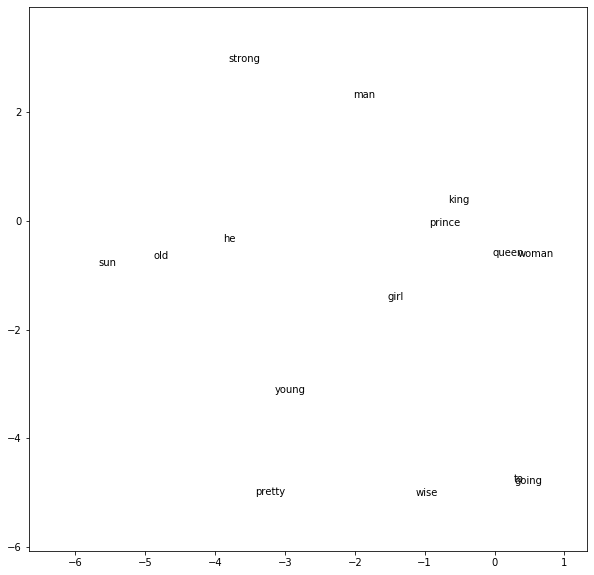

In [140]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()